## This notebook demonstrates a single-reaction prediction using a trained ARC model.

## 1. Setup
Load libraries, define thresholds, and set device.


In [1]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import os
from model import *
from utils import *
from pairdata import *
from dataset import *
from utils_data import *
import json
from plots import *

## 2. Load Test Example

In [2]:
i = 18 
dataset_path = '../datasets/processed/'
test_set = torch.load(os.path.join(dataset_path, 'test.pt'))
test_loader = DataLoader(test_set[i:i+1], batch_size=1, shuffle=False)
data = next(iter(test_loader))

atom_labels = data.rc_atoms.float()
bond_labels = data.rc_bonds.long()
bond_binary_labels = (bond_labels > 0).long()
am_labels = data.p2r_mapper  
edge_index = data.edge_index_p.cpu().detach().numpy().T  
reaction = data.reaction_smiles[0]
dual_data = get_dual_pairdata(data) 
dual_data = dual_data.to(device)  


## 3. Load Model and Parameters

In [ ]:
model_path = 'results/arc' 

with open(f'{model_path}/hyperparameters.json', 'r') as f:
    params = json.load(f)

encoder = ARC(
    input_dim=params['node_feature_dim'],
    hidden_dim=params['embedding_dim'],
    edge_attr_dim=params['edge_feature_dim'],
    edge_hidden_dim=params['edge_hidden_dim'],
    dual_edge_attr_dim = params['node_feature_dim'],
    n_heads=params['n_heads'],
    n_layers=params['num_layers'],
    cat=params['cat'],
    learning_skip_connection=True
).to(device)

encoder.load_state_dict(torch.load(f'{model_path}/best_model.pt'))
encoder.eval()

threshold_atoms = 0.566
threshold_bonds = 0.550

soft_matching, atom_change_logits, bond_logits = encoder(
    data.x_p, data.edge_index_p, data.edge_attr_p, data.batch_p,
    data.x_r, data.edge_index_r, data.edge_attr_r, data.batch_r, 
    dual_data.edge_index_p, dual_data.edge_attr_p, 
    mapping_matrix=None, use_ground_truth=False, symmetry_data=data)  

## 4. Atom Mapping Prediction

In [4]:
symmetry_aware_mapping = get_symmetry_aware_atom_mapping(soft_matching, data)
symmetry_aware_accuracies =  get_symmetry_aware_accuracy(symmetry_aware_mapping, data)
print(f'Test Symmetry Aware Accuracy: {round(symmetry_aware_accuracies, 3) * 100} %')
am_labels = data.p2r_mapper
predicted_matches = select_matched_nodes(soft_matching)
symmetry_aware_mapping = get_symmetry_aware_atom_mapping(soft_matching, data)
print("eq_as", data.eq_as)
print("Ground truth", am_labels)
print("Predicted", predicted_matches)
print("Symmetry aware", symmetry_aware_mapping)
mismatched_indices = torch.where(am_labels != symmetry_aware_mapping)[0]
print("Mismatched indices:", mismatched_indices.tolist())
print('actual to predicted mapping', am_labels[mismatched_indices], symmetry_aware_mapping[mismatched_indices])


Test Symmetry Aware Accuracy: 100.0 %
eq_as [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16, 20}, {17, 19}, {18}]]
Ground truth tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 16, 17, 18, 19, 20])
Predicted tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 16, 17, 18, 17, 16]])
Symmetry aware tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 16, 17, 18, 19, 20])
Mismatched indices: []
actual to predicted mapping tensor([], dtype=torch.int64) tensor([], dtype=torch.int64)


## 5. Atom Reactivity Prediction

In [5]:
y_true_atom = atom_labels.cpu().detach().numpy()
atom_probs = y_pred_probs_atom = torch.sigmoid(atom_change_logits).cpu().detach().numpy()
y_preds_atom = (y_pred_probs_atom > params['threshold_atoms']).astype(int)
avg_test_atom_acc = np.mean(np.array(y_true_atom) == np.array(y_preds_atom))
print(f'Test Atom Accuracy: {round(avg_test_atom_acc, 3) * 100} %')
atom_metrics = compute_metrics(np.array(y_true_atom), np.array(y_preds_atom), threshold=params['threshold_atoms'], task_name="atom")
print(f'Test Atom F1: {round(atom_metrics["atom_f1"], 3)}')
print(f'Test Atom AUC: {round(atom_metrics["atom_auc"], 3)}')
print(f'Test Atom Precision: {round(atom_metrics["atom_precision"], 3)}')
print(f'Test Atom Recall: {round(atom_metrics["atom_recall"], 3)}')
print('real atoms labels', np.where(y_true_atom == 1)[0])
print('predited atoms', np.where(y_preds_atom == 1)[0])


Test Atom Accuracy: 100.0 %
Test Atom F1: 1.0
Test Atom AUC: 1.0
Test Atom Precision: 1.0
Test Atom Recall: 1.0
real atoms labels [ 8 10]
predited atoms [ 8 10]


## 6. Bond Reactivity Prediction

In [6]:
y_true_bond = bond_binary_labels.cpu().detach().numpy()
bond_probs =y_pred_probs_bond = torch.sigmoid(bond_logits).cpu().detach().numpy()
y_preds_bond = (y_pred_probs_bond > threshold_bonds).astype(int)
avg_test_bond_acc = np.mean(np.array(y_true_bond) == np.array(y_preds_bond))
print(f'Test Bond Accuracy: {round(avg_test_bond_acc, 3) * 100} %')
bond_metrics = compute_metrics(np.array(y_true_bond), np.array(y_preds_bond), threshold=threshold_bonds, task_name="bond")
print(f'Test Bond F1: {round(bond_metrics["bond_f1"], 3)}')
print(f'Test Bond AUC: {round(bond_metrics["bond_auc"], 3)}')
print(f'Test Bond Precision: {round(bond_metrics["bond_precision"], 3)}')
print(f'Test Bond Recall: {round(bond_metrics["bond_recall"], 3)}')
print('real bonds', np.where(np.isin(y_true_bond, [1, 2]))[0])
print('predited bonds', np.where(np.isin(y_preds_bond, [1, 2]))[0])


Test Bond Accuracy: 100.0 %
Test Bond F1: 1.0
Test Bond AUC: 1.0
Test Bond Precision: 1.0
Test Bond Recall: 1.0
real bonds [18 19]
predited bonds [18 19]


In [7]:
hit1 = calculate_top_n_edit_accuracy(atom_probs, atom_labels, bond_probs, bond_labels, edge_index, top_n=1)
print('Top 1 hit:', hit1)

Top 1 hit: 1


## 7. Visualization of Ground Truth Reaction

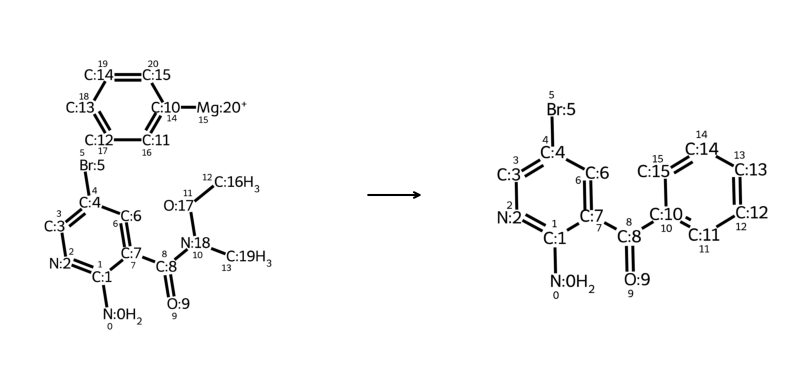

In [52]:
draw_gt_reaction(i, reaction)

## 8. Visualization of Predicted Mapping and Reaction Centers

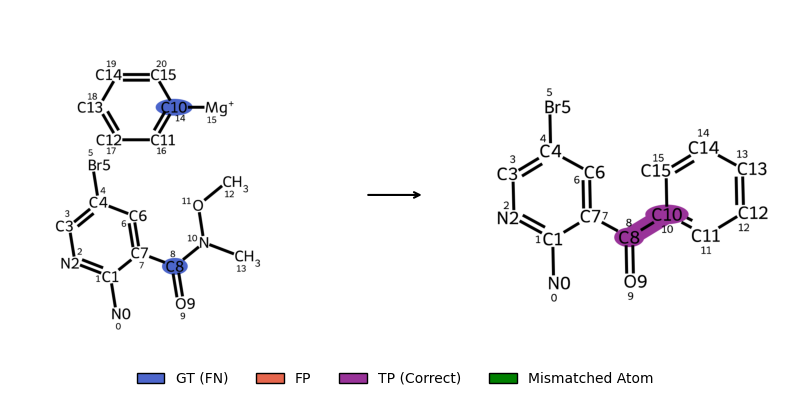

In [8]:
draw_reaction_predictions_highlight(i, data, y_pred_probs_atom,y_pred_probs_bond, symmetry_aware_mapping, threshold_atoms, threshold_bonds)  

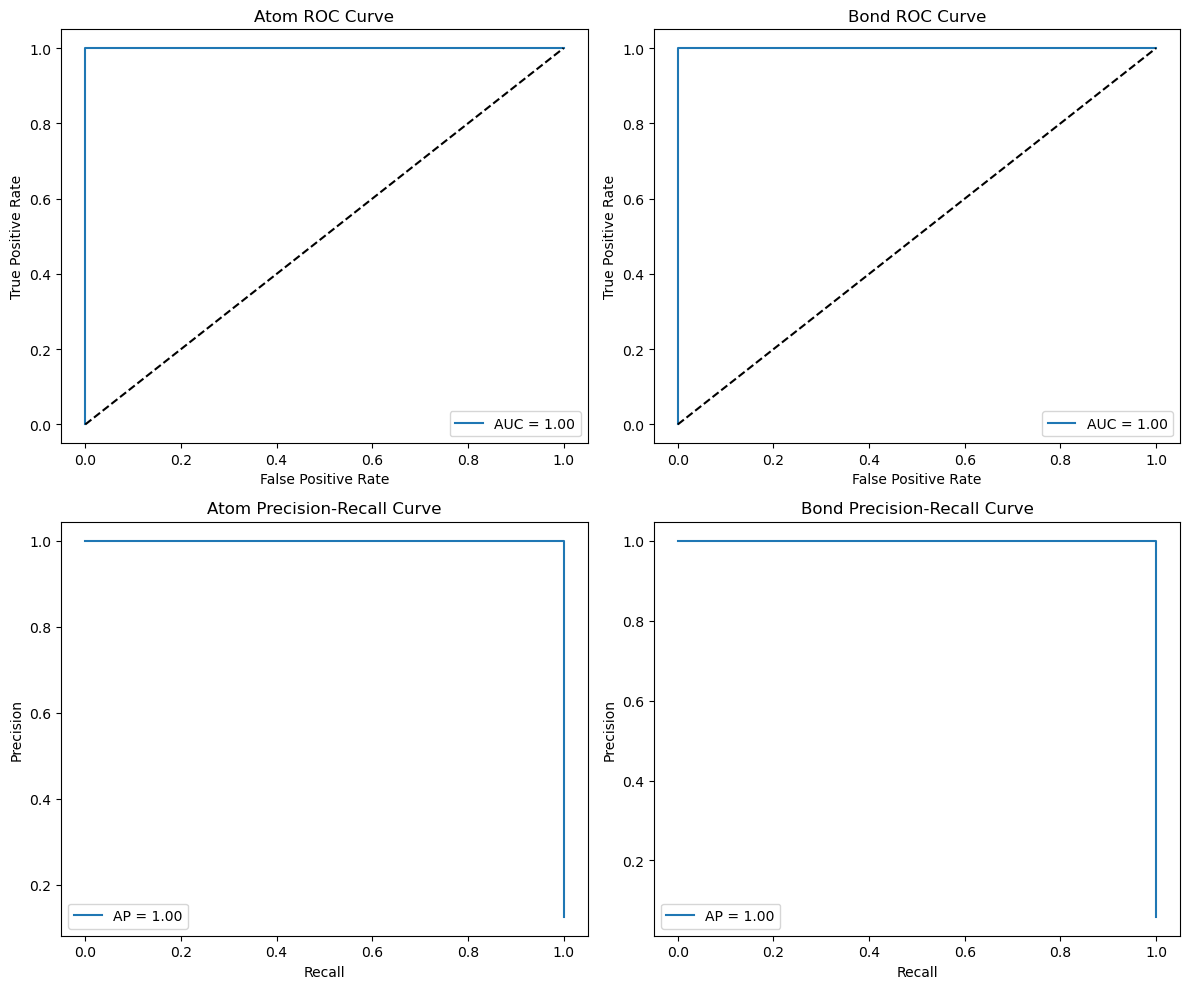

In [10]:
plot_atom_bond_roc_pr_curves(y_true_atom, y_pred_probs_atom,y_true_bond, y_pred_probs_bond)

In [13]:
import pandas as pd

atom_stats = {
    "Accuracy": avg_test_atom_acc,
    "F1": atom_metrics["atom_f1"],
    "AUC": atom_metrics["atom_auc"],
    "Precision": atom_metrics["atom_precision"],
    "Recall": atom_metrics["atom_recall"]
}

bond_stats = {
    "Accuracy": avg_test_bond_acc,
    "F1": bond_metrics["bond_f1"],
    "AUC": bond_metrics["bond_auc"],
    "Precision": bond_metrics["bond_precision"],
    "Recall": bond_metrics["bond_recall"]
}

report_data = {
    "Metric": ["Accuracy", "F1 Score", "AUC", "Precision", "Recall", "AMAP Accuracy"],
    "Atom": [round(atom_metrics["atom_f1"], 3), round(atom_metrics["atom_auc"], 3), round(atom_metrics["atom_precision"], 3), round(atom_metrics["atom_recall"], 3), round(avg_test_atom_acc, 3), None], 
    "Bond": [round(bond_metrics["bond_f1"], 3), round(bond_metrics["bond_auc"], 3), round(bond_metrics["bond_precision"], 3), round(bond_metrics["bond_recall"], 3), round(avg_test_bond_acc, 3), None],
    "AMAP": [None, None, None, None, None, round(symmetry_aware_accuracies, 3)]}
df_report = pd.DataFrame(report_data)
df_report.set_index("Metric", inplace=True)
df_report


,Atom,Bond,AMAP
Metric,,,
Accuracy,1.0,1.0,NaN
F1 Score,1.0,1.0,NaN
AUC,1.0,1.0,NaN
Precision,1.0,1.0,NaN
Recall,1.0,1.0,NaN
AMAP Accuracy,NaN,NaN,1.0
